In [1]:
import jax
import jax.numpy as jnp
from sklearn.linear_model import LogisticRegression
import os
import pickle
from variational.exponential_family import GenericMeanFieldNormalDistribution, NormalDistribution, MeanFieldNormalDistribution
from experiments.logisticRegression.mnist.load_mnist import mnist_dataset
import matplotlib.pyplot as plt

OUTPUT_PATH = "./output_mean_field/"
OP_key = jax.random.PRNGKey(0)
logreg = LogisticRegression(penalty=None, fit_intercept=False)
jax.config.update("jax_enable_x64", True)
mnist_train, mnist_test = mnist_dataset(return_test=True, flip=False)
flipped_predictors, response = mnist_train
flipped_predictors_test, response_test = mnist_test
N, dim = flipped_predictors.shape

2025-03-28 12:02:54.342711: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
PKLs = []
PKL_titles = []
for file in os.listdir(OUTPUT_PATH):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(OUTPUT_PATH + "/"+ file, "rb")))
        PKL_titles.append(str(file))

full_gaussian = GenericMeanFieldNormalDistribution(dimension=dim)

In [5]:
logreg.fit(flipped_predictors, response)
test_prediction = logreg.predict(flipped_predictors_test)
jnp.sum(test_prediction != response_test) / len(response_test)

Array(0.01074719, dtype=float64)

In [6]:
from sklearn.metrics import log_loss

log_loss(response_test, logreg.predict_proba(flipped_predictors_test))
log_loss(response, logreg.predict_proba(flipped_predictors))

0.0010100226273692804

In [3]:
PKL_titles

['heuristic_gaussian_Nicolas_25_10000_Seq3_u10_[0 4].pkl',
 'heuristic_gaussian_Nicolas_25_10000_Seq1_u10_[0 4].pkl',
 'res_mfg_advi_blackjax_25_10000_0.001.pkl']

In [3]:
def missclassification_over_test(betas):
    u = (flipped_predictors_test@betas.T).T
    classification = jax.vmap(lambda x: (x<0)*(-1.) + (x>0)*1.)(u)
    rates = jnp.mean(classification != response_test, axis=-1)
    return rates

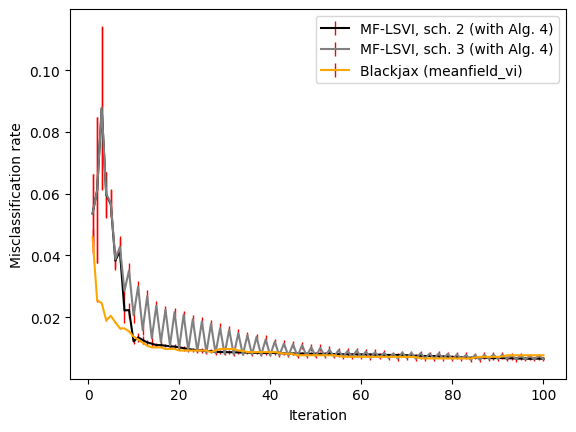

In [17]:
colors = ["black", "gray", "orange"]
labels = ["MF-LSVI, sch. 2 (with Alg. 4)", "MF-LSVI, sch. 3 (with Alg. 4)",
         "Blackjax (meanfield_vi)"]
for idx in [0, 1]:
    """
    Computing the mean of the regression coefficients, for each repetitions, iterations
    Computing the rates of missclasification
    """
    my_etas = PKLs[idx]['res'][..., :-1]
    d = my_etas.shape[-1]
    shape = my_etas.shape
    my_etas = my_etas.reshape((-1, d))
    my_mean_betas = jax.vmap(full_gaussian.get_mean_cov)(my_etas)[0]
    rates = missclassification_over_test(my_mean_betas)
    rates = rates.reshape(shape[:-1]).T
    start = 1
    end = 100+1
    plt.errorbar(x=range(start, end), y=rates[start:end].mean(axis=-1), yerr=rates[start:end].std(axis=-1), 
                 label=labels[idx], ecolor="red", color=colors[idx],
                elinewidth=1.)

idx=2
my_means = PKLs[idx]['states'][0]
shape = my_means.shape
my_means = my_means.reshape((-1, dim))
rates = missclassification_over_test(my_means).reshape(shape[:-1]).T
plt.errorbar(x=range(start, end), y=rates[start:end].mean(axis=-1), yerr=rates[start:end].std(axis=-1),
             label=labels[idx], ecolor="red", color=colors[idx],
            elinewidth=1.)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Misclassification rate")
plt.savefig("MNIST_missclassification_rate_mean_std_over_100_it.pdf")

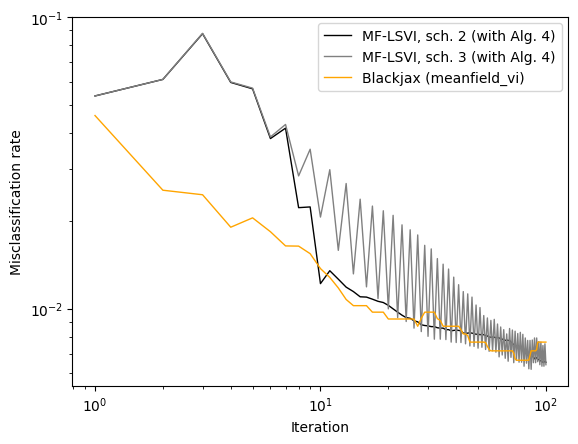

In [18]:
colors = ["black", "gray", "orange"]
labels = ["MF-LSVI, sch. 2 (with Alg. 4)", "MF-LSVI, sch. 3 (with Alg. 4)",
         "Blackjax (meanfield_vi)"]
for idx in [0, 1]:
    """
    Computing the mean of the regression coefficients, for each repetitions, iterations
    Computing the rates of missclasification
    """
    my_etas = PKLs[idx]['res'][..., :-1]
    d = my_etas.shape[-1]
    shape = my_etas.shape
    my_etas = my_etas.reshape((-1, d))
    my_mean_betas = jax.vmap(full_gaussian.get_mean_cov)(my_etas)[0]
    rates = missclassification_over_test(my_mean_betas)
    rates = rates.reshape(shape[:-1]).T
    start = 1
    end = 100+1
    plt.loglog(range(start, end), rates[start:end].mean(axis=-1), 
                 label=labels[idx], color=colors[idx], linewidth=1)

idx=2
my_means = PKLs[idx]['states'][0]
shape = my_means.shape
my_means = my_means.reshape((-1, dim))
rates = missclassification_over_test(my_means).reshape(shape[:-1]).T
plt.loglog(range(start, end), rates[start:end].mean(axis=-1),
             label=labels[idx], color=colors[idx], linewidth=1)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Misclassification rate")
plt.savefig("MNIST_missclassification_rate_log_log_mean_100it.pdf")